# Bank Marketing Campaign Analysis
# Author: Adeyeye Blessing Temidayo
# CIN: PIT/DEC25/10676
# Date: January 2026

PROJECT OVERVIEW
================
This analysis predicts customer subscription to term deposits based on direct marketing 
campaign data from a Portuguese banking institution. The data includes customer demographics, 
financial information, and campaign contact history.

BUSINESS OBJECTIVE
==================
Develop a predictive model to identify customers most likely to subscribe to term deposits,
enabling the bank to:
1. Optimize marketing campaign targeting
2. Reduce campaign costs by focusing on high-probability customers
3. Improve conversion rates and customer satisfaction

DATA SOURCE
===========
Dataset: Bank Marketing Dataset (UCI Machine Learning Repository)
Features: 17 attributes including customer demographics, financial status, and campaign details
Target: Binary classification (subscription yes/no)
Class Distribution: Highly imbalanced (~88% no, ~12% yes)

METHODOLOGY
===========
1. Exploratory Data Analysis
2. Feature Engineering & Preprocessing
3. Baseline Model Establishment
4. Multiple Model Comparison (Logistic Regression, Decision Tree, Random Forest, XGBoost)
5. Hyperparameter Optimization
6. Business-Oriented Evaluation

## Environment Setup & Libraries  

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve,
    make_scorer
)

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Handle class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Visualization settings
sns.set_style("whitegrid")
sns.set_palette("colorblind")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (12, 6)



## Data Loading

In [2]:
# Load data
df = pd.read_csv("bank-full.csv", sep=';')
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Data inspection

In [3]:
# Overview of the data
print(f"\nData info")
df.info()


Data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
# check for duplicates
print(f"\nNumber of duplicates")
df.duplicated().sum()


Number of duplicates


np.int64(0)

In [5]:
unknown_counts = (df == 'unknown').sum()
print(f"\nCount of unknown:{unknown_counts}")


Count of unknown:age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64


In [6]:
# Statistical summary of Numerical data
print(f"\n Numerical feature statistical summary")
df.describe()


 Numerical feature statistical summary


,age,balance,day,duration,campaign,pdays,previous
count,45211.0000,45211.0000,45211.0000,45211.0000,45211.0000,45211.0000,45211.0000
mean,40.9362,1362.2721,15.8064,258.1631,2.7638,40.1978,0.5803
std,10.6188,3044.7658,8.3225,257.5278,3.0980,100.1287,2.3034
min,18.0000,-8019.0000,1.0000,0.0000,1.0000,-1.0000,0.0000
25%,33.0000,72.0000,8.0000,103.0000,1.0000,-1.0000,0.0000
50%,39.0000,448.0000,16.0000,180.0000,2.0000,-1.0000,0.0000
75%,48.0000,1428.0000,21.0000,319.0000,3.0000,-1.0000,0.0000
max,95.0000,102127.0000,31.0000,4918.0000,63.0000,871.0000,275.0000


In [7]:
# Categorical feature summary
print(f"\nCategorical feature summary")
df.describe(include="object")


Categorical feature summary


,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


In [8]:
# Check missing values
print(f"\nNumber of missing values")
df.isnull().sum()


Number of missing values


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

## Exploratory Data Analysis (EDA)

In [9]:
# Target variable distribution
print(f"\n Target Variable Distribution")
target_counts = df['y'].value_counts()
target_dist = df['y'].value_counts(normalize=True)
print(target_dist)
print(f"\n Class imbalance ratio: {target_dist['no'] / target_dist['yes']:.2f}:1")


 Target Variable Distribution
y
no     0.883
yes    0.117
Name: proportion, dtype: float64

 Class imbalance ratio: 7.55:1


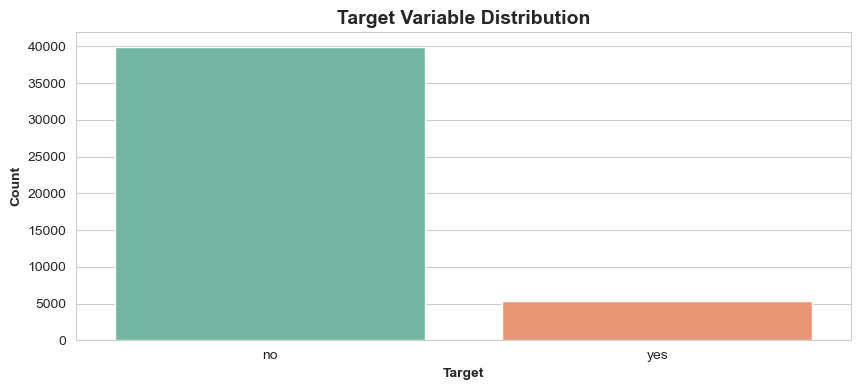

In [10]:
# Plot of the target variable distribution
plt.figure(figsize=(10,4))
sns.countplot(data=df, x="y", palette="Set2")
plt.xlabel("Target", fontweight='bold')
plt.ylabel("Count", fontweight='bold')
plt.title("Target Variable Distribution",fontsize=14, fontweight='bold')
plt.savefig('images/Target Variable Distribution.png', dpi=300, bbox_inches='tight')
plt.show();

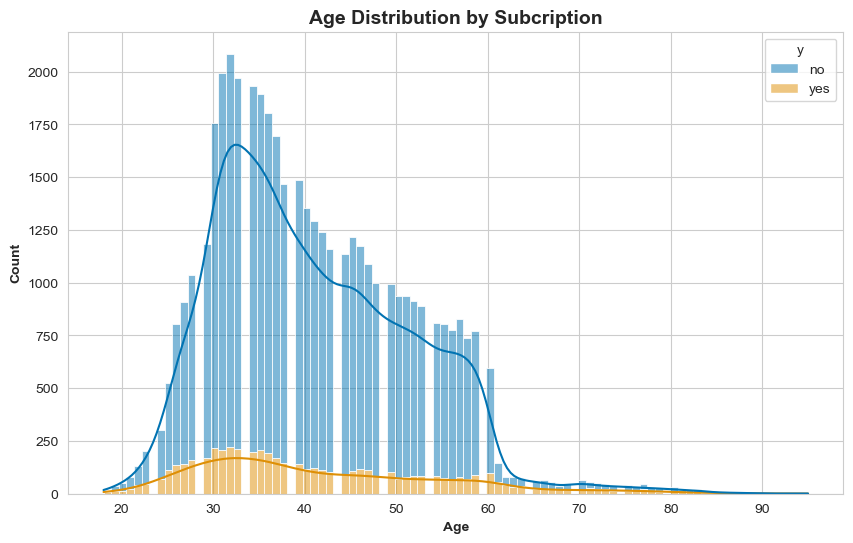

In [11]:
# Age distribution vs target
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='y', multiple="stack", kde=True)
plt.title('Age Distribution by Subcription', fontsize=14, fontweight='bold')
plt.xlabel('Age', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.savefig('images/Age Distribution by Subcription.png', dpi=300, bbox_inches='tight')
plt.show();


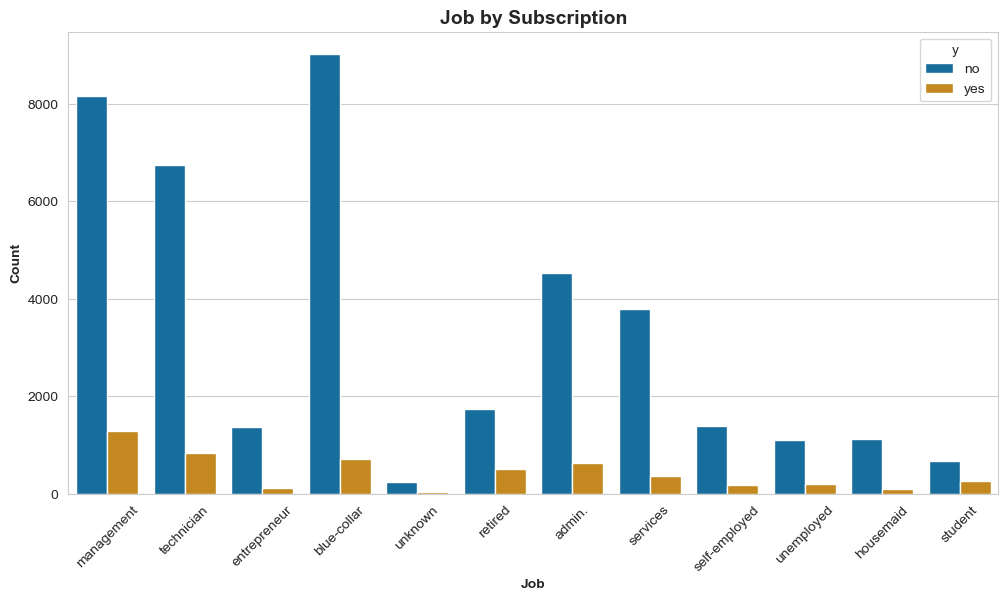

In [13]:
# Plot of Job vs Target Subscription
plt.figure(figsize=(12, 6))
sns.countplot(x='job', hue='y', data=df)
plt.xticks(rotation=45)
plt.title('Job by Subscription', fontsize=14, fontweight='bold')
plt.xlabel('Job', fontweight='bold')
plt.ylabel('Count',fontweight='bold')
plt.savefig('images/Job by Subscription.png', dpi=300, bbox_inches='tight')
plt.show()

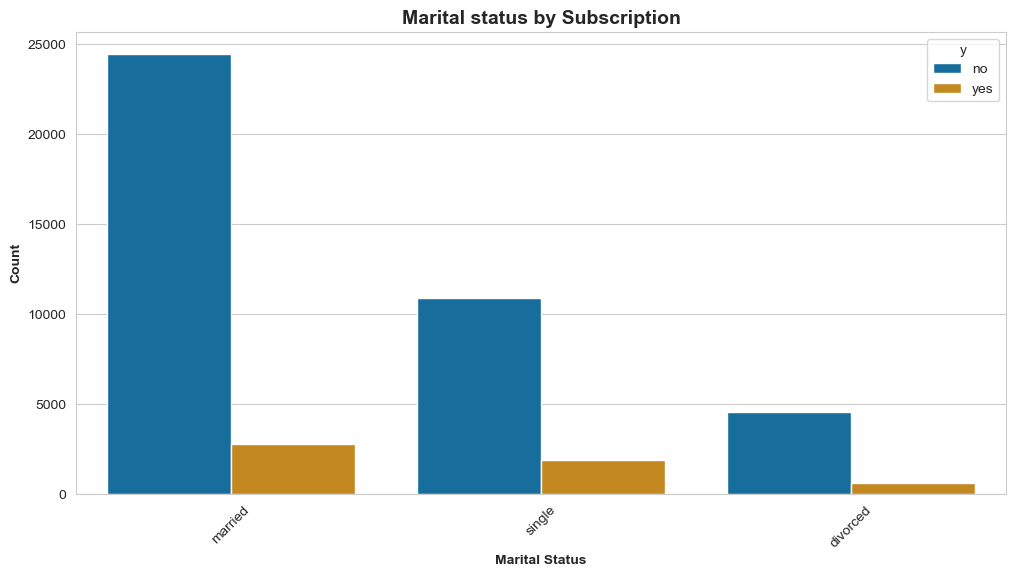

In [14]:
# Plot of Job vs Target Subscription
plt.figure(figsize=(12, 6))
sns.countplot(x='marital', hue='y', data=df)
plt.xticks(rotation=45)
plt.title('Marital status by Subscription', fontsize=14, fontweight='bold')
plt.xlabel("Marital Status", fontweight='bold')
plt.ylabel("Count", fontweight='bold')
plt.savefig('Marital status by Subscription.png', dpi=300, bbox_inches='tight')
plt.show()

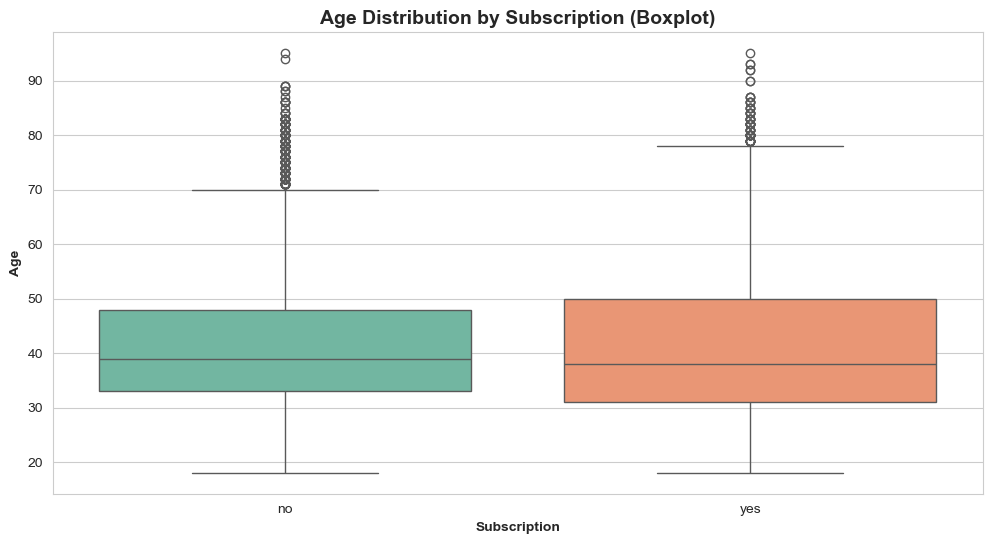

In [15]:
# Box plot of age distribution by subscription
sns.boxplot(data=df, x='y', y='age', palette='Set2')
plt.title('Age Distribution by Subscription (Boxplot)', fontsize=14, fontweight='bold')
plt.xlabel('Subscription', fontweight='bold')
plt.ylabel('Age', fontweight='bold')
plt.savefig('images/Age Distribution by Subscription.png', dpi=300, bbox_inches='tight')
plt.show()

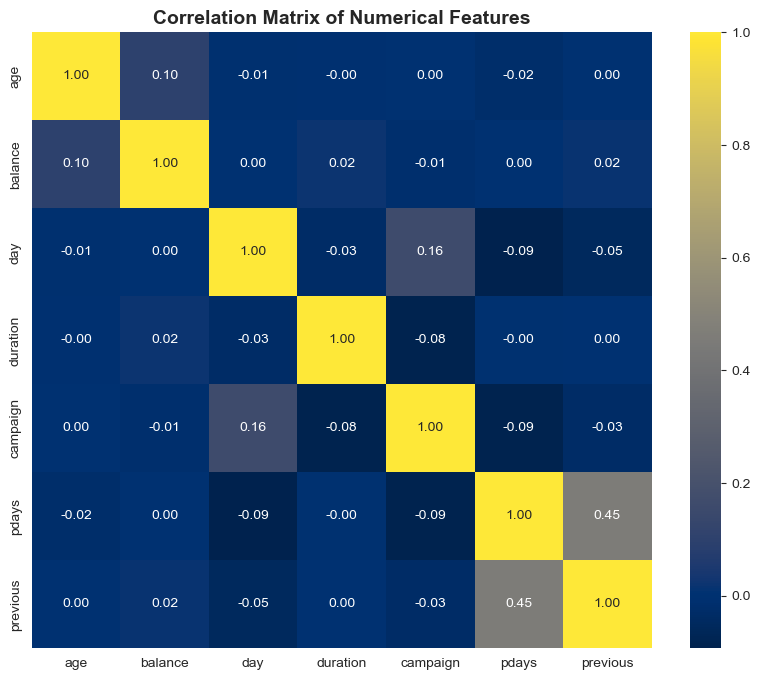

In [16]:
# Plot of correlation matrix of numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='cividis', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
plt.savefig('images/Correlation Matrix of Numerical Features.png', dpi=300, bbox_inches='tight')
plt.show()

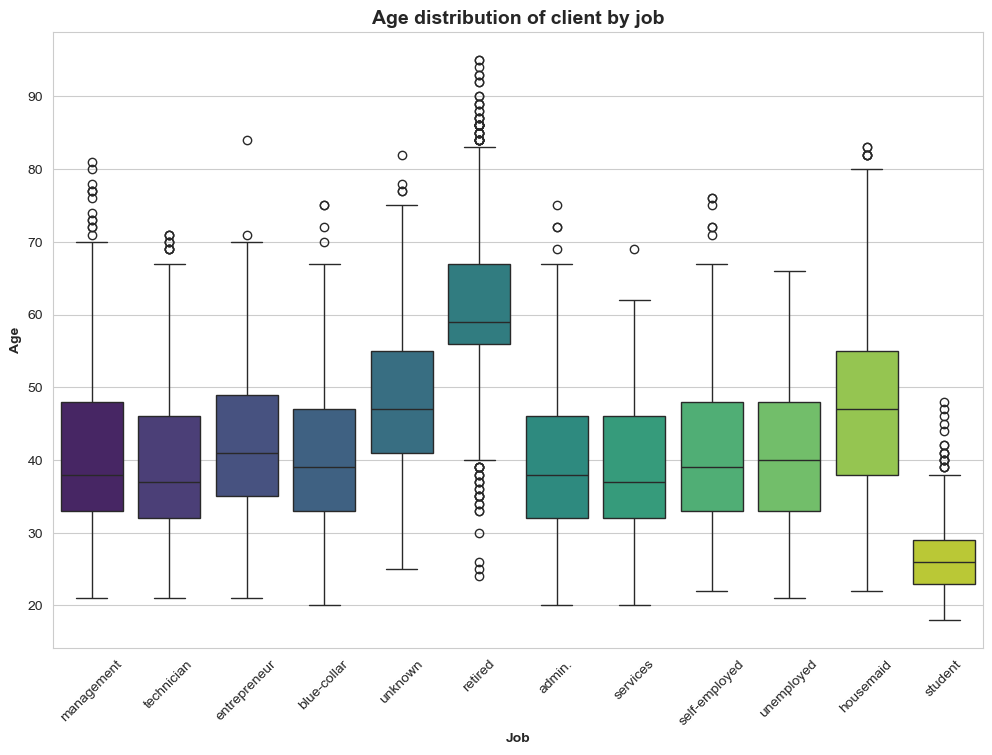

In [17]:
# plot of Age distribution of clients by their jobs
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x="job", y="age", palette="viridis", hue="job", legend=False)
plt.xlabel("Job", fontweight='bold')
plt.ylabel("Age",fontweight='bold')
plt.title("Age distribution of client by job", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.savefig('images/Age distribution of client by job.png', dpi=300, bbox_inches='tight')
plt.show()

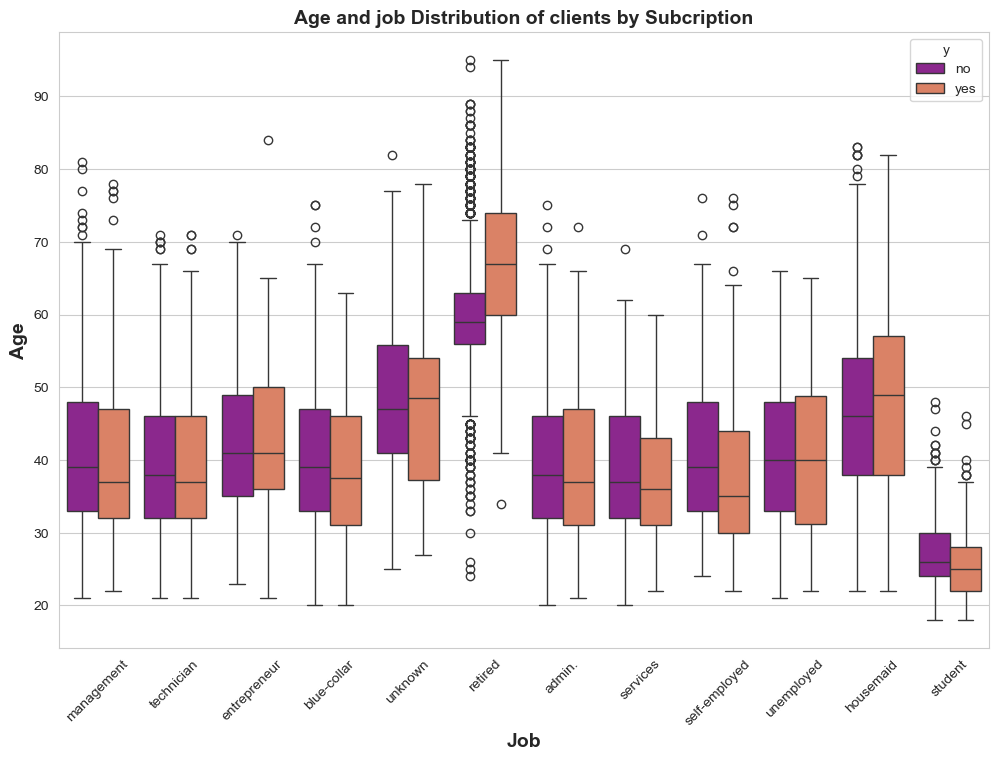

In [18]:
# Age distribution of client by job Using the target Variable
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x="job", y="age", palette="plasma", hue="y", legend=True)
plt.xlabel("Job",fontsize=14, fontweight='bold')
plt.ylabel("Age", fontsize=14, fontweight='bold')
plt.title("Age and job Distribution of clients by Subcription",fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.savefig('images/Age and job Distribution of clients by Subcription.png', dpi=300, bbox_inches='tight')
plt.show()

## Data Preprocessing

In [19]:
data = df.copy()

In [20]:
# Encoding the month column
month_dict = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

data["month"] = data["month"].map(month_dict)

In [21]:
# Encode education (ordinal)
education_map = {"unknown": 0, "primary": 1, "secondary": 2, "tertiary": 3}
data["education"] = data["education"].map(education_map)

In [22]:
# Distribution of Age 
data['age'].describe()

count    45211.0000
mean        40.9362
std         10.6188
min         18.0000
25%         33.0000
50%         39.0000
75%         48.0000
max         95.0000
Name: age, dtype: float64

In [23]:
# Using Quantile to aid age binning
age_quantiles = data['age'].quantile([0, 0.25, 0.5, 0.75, 1.0])
age_quantiles

0.00    18.0
0.25    33.0
0.50    39.0
0.75    48.0
1.00    95.0
Name: age, dtype: float64

In [24]:
# classifying "age" into four bins by age bracket namely: "young", "mid_age", "about_to_retire", and retirement_age.                                                        
age_bins= [0, 30, 45, 60, 100]
age_labels=['young', 'mid_age', 'about_to_retire', 'retirement_age']
data['age_category'] =  pd.cut(data['age'], bins=age_bins, labels=age_labels, right=False)

In [25]:
# Distribution of age by category
data['age_category'].value_counts().sort_index()

age_category
young               5273
mid_age            24274
about_to_retire    13880
retirement_age      1784
Name: count, dtype: int64

In [26]:
# clustering 'job' columns for encoding using a function
job_clusters = {
    'technician': 'professional',
    'management': 'professional',
    'admin.': 'professional',
    'services': 'service_manual',
    'blue-collar': 'service_manual',
    'housemaid': 'service_manual',
    'self-employed': 'business',
    'entrepreneur': 'business',
    'unemployed': 'not_working',
    'unknown': 'not_working',
    'retired': 'retired_student',
    'student': 'retired_student'
    }

data['new_job'] = data['job'].map(job_clusters)
print(f"\nDistribution of job categories")
print(data['new_job'].value_counts())


Distribution of job categories
new_job
professional       22226
service_manual     15126
retired_student     3202
business            3066
not_working         1591
Name: count, dtype: int64


In [27]:
# Encoding of categorical variables
binary_cols = ["default", "housing", "loan"]
data[binary_cols] = data[binary_cols].replace({'no': 0, 'yes': 1})
# Encode contact where cellular and telephone = 1 and unknown = 0
data["contact"] = data["contact"].replace({'unknown': 0, 'cellular': 1, 'telephone': 1})
# Encode 'pdays' column
data["contacted_before"] = (data["pdays"] != -1).astype(int)
# Encode 'poutcome' column
data["poutcome"] = data["poutcome"].apply( lambda x: 1 if x == 'success' else 0).astype(int)
# Encoding the target variable
data["y"] = data["y"].map({'no': 0, 'yes': 1})

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               45211 non-null  int64   
 1   job               45211 non-null  object  
 2   marital           45211 non-null  object  
 3   education         45211 non-null  int64   
 4   default           45211 non-null  int64   
 5   balance           45211 non-null  int64   
 6   housing           45211 non-null  int64   
 7   loan              45211 non-null  int64   
 8   contact           45211 non-null  int64   
 9   day               45211 non-null  int64   
 10  month             45211 non-null  int64   
 11  duration          45211 non-null  int64   
 12  campaign          45211 non-null  int64   
 13  pdays             45211 non-null  int64   
 14  previous          45211 non-null  int64   
 15  poutcome          45211 non-null  int64   
 16  y                 4521

In [29]:
# drop irrelevant and redundant columns
data.drop(["pdays", "job", "age"], axis=1, inplace=True)

In [30]:
# One-hot encoding on 'marital', 'age_category', 'new_job' columns
clean_df = pd.get_dummies(data, columns=['marital', 'age_category', 'new_job'], drop_first=True)
print(f"\nClean Data shape: {clean_df.shape}")
print(f"\nCleaned Data columns:\n{list(clean_df.columns)}")


Clean Data shape: (45211, 23)

Cleaned Data columns:
['education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'previous', 'poutcome', 'y', 'contacted_before', 'marital_married', 'marital_single', 'age_category_mid_age', 'age_category_about_to_retire', 'age_category_retirement_age', 'new_job_not_working', 'new_job_professional', 'new_job_retired_student', 'new_job_service_manual']


## Data Modeling And Evaluation

In [31]:
# split data into features and target
# Removing "duration" from set makes the model a predictive tool rather than a post-call analysis
# providing the bank insight on who to call.
X = clean_df.drop(['y', 'duration'], axis=1)
y = clean_df['y']

# Train-test split with stratification 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
# Distribution of training and target sets
print(f"Training set target distribution:\n{y_train.value_counts(normalize=True)}")


Training set size: (36168, 21)
Test set size: (9043, 21)
Training set target distribution:
y
0    0.883
1    0.117
Name: proportion, dtype: float64


In [32]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Identify feature types for preprocessing
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Remove binary columns from scaling since they are already 0 and 1
binary_features = ['default', 'housing', 'loan', 'contact', 'poutcome', 'contacted_before']
numeric_features = [col for col in numeric_features if col not in binary_features]

print(f"\nFeatures to scale: {numeric_features}")




Features to scale: ['education', 'balance', 'day', 'month', 'campaign', 'previous']


In [33]:
# preprocessor to scale continuous features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('pass', 'passthrough', [col for col in X_train.columns if col not in numeric_features])
    ],
    remainder='passthrough'
)

In [34]:
print(X_train.dtypes)

education                       int64
default                         int64
balance                         int64
housing                         int64
loan                            int64
contact                         int64
day                             int64
month                           int64
campaign                        int64
previous                        int64
poutcome                        int64
contacted_before                int64
marital_married                  bool
marital_single                   bool
age_category_mid_age             bool
age_category_about_to_retire     bool
age_category_retirement_age      bool
new_job_not_working              bool
new_job_professional             bool
new_job_retired_student          bool
new_job_service_manual           bool
dtype: object


## Model training with cross validation

In [35]:
# Define models 
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
}


In [36]:
# Cross validation using SMOTE due to class imbalance

cv_results = {}
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])
    
    cv_auc = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    cv_results[name] = cv_auc.mean()
    print(f"{name:25s}  CV ROC-AUC: {cv_auc.mean()})")

Logistic Regression        CV ROC-AUC: 0.7474132463729661)
Decision Tree              CV ROC-AUC: 0.6114753576459431)
Random Forest              CV ROC-AUC: 0.7559129199152361)
XGBoost                    CV ROC-AUC: 0.7784815568338337)


## Model Hyperparameter Tuning

In [38]:
# Logistic Regression
print("\nTuning Logistic Regression")
logReg_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

logReg_params = {
    'model__C': [0.001, 0.005, 0.01, 0.05],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear']
}

logReg_grid = GridSearchCV(logReg_pipe, logReg_params, cv=5, scoring='roc_auc', n_jobs=1, verbose=1)
logReg_grid.fit(X_train, y_train)
print(f"Best params: {logReg_grid.best_params_}")
print(f"Best CV score: {logReg_grid.best_score_:.4f}")


Tuning Logistic Regression
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'model__C': 0.005, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best CV score: 0.7486


In [39]:
# Decision Tree hyperparameter without SMOTE because it uses class_weight which helps with class imbalance
print("\nTuning Decision Tree")
dt_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

dt_params = {
    'model__max_depth': [3, 5, 7, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__criterion': ['gini', 'entropy']
}

dt_grid = GridSearchCV(dt_pipe, dt_params, cv=5, scoring='roc_auc', n_jobs=1, verbose=1)
dt_grid.fit(X_train, y_train)
print(f"Best params: {dt_grid.best_params_}")
print(f"Best CV score: {dt_grid.best_score_:.4f}")


Tuning Decision Tree
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'model__criterion': 'entropy', 'model__max_depth': 7, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10}
Best CV score: 0.7587


In [41]:
print("\nTuning Random Forest")
rndfr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])

rndfr_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None,15],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
}

rndfr_grid = GridSearchCV(rndfr_pipe, rndfr_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
rndfr_grid.fit(X_train, y_train)
print(f"Best params: {rndfr_grid.best_params_}")
print(f"Best CV score: {rndfr_grid.best_score_:.4f}")


Tuning Random Forest
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'model__max_depth': 15, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV score: 0.7740


In [42]:
print("\nTuning XGBoost")
xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(eval_metric='logloss', random_state=42))
])

xgb_params = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.8, 1.0, 0.9]
}

xgb_grid = GridSearchCV(xgb_pipe, xgb_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)
print(f"Best params: {xgb_grid.best_params_}")
print(f"Best CV score: {xgb_grid.best_score_:.4f}")


Tuning XGBoost
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best params: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 300, 'model__subsample': 0.8}
Best CV score: 0.7866


## Model Evaluation

In [43]:
# Model evaluations
print("MODEL EVALUATION ON TEST SET")

best_models = {
    "Logistic Regression": logReg_grid.best_estimator_,
    "Decision Tree": dt_grid.best_estimator_,
    "Random Forest": rndfr_grid.best_estimator_,
    "XGBoost": xgb_grid.best_estimator_
}

# Detailed evaluation
results = []
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'ROC-AUC': roc_auc,
        'Avg Precision': avg_precision
    })
    
    print(f"\n{name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# Results DataFrame
results_df = pd.DataFrame(results)
print("SUMMARY OF ALL MODELS")
print(results_df.to_string(index=False))

MODEL EVALUATION ON TEST SET

Logistic Regression
Accuracy: 0.7030
ROC-AUC: 0.7557
Average Precision: 0.3738

Confusion Matrix:
[[5643 2342]
 [ 344  714]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.71      0.81      7985
           1       0.23      0.67      0.35      1058

    accuracy                           0.70      9043
   macro avg       0.59      0.69      0.58      9043
weighted avg       0.86      0.70      0.75      9043


Decision Tree
Accuracy: 0.8158
ROC-AUC: 0.7609
Average Precision: 0.3946

Confusion Matrix:
[[6796 1189]
 [ 477  581]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      7985
           1       0.33      0.55      0.41      1058

    accuracy                           0.82      9043
   macro avg       0.63      0.70      0.65      9043
weighted avg       0.86      0.82      0.83      9043


Random Forest
Accuracy

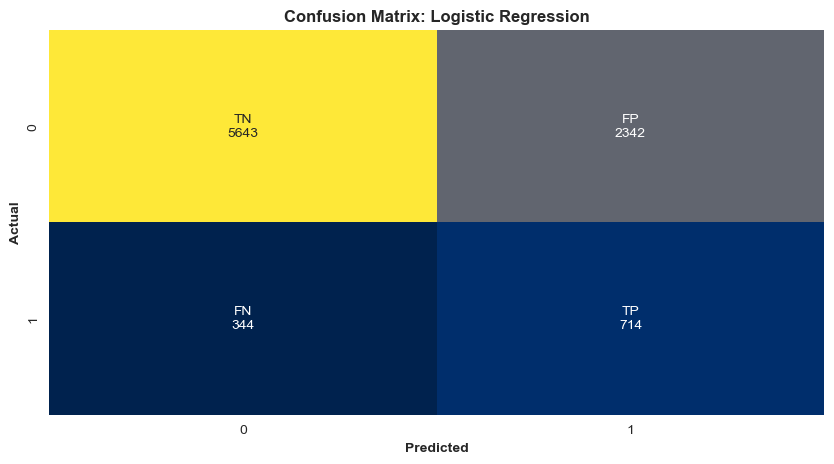

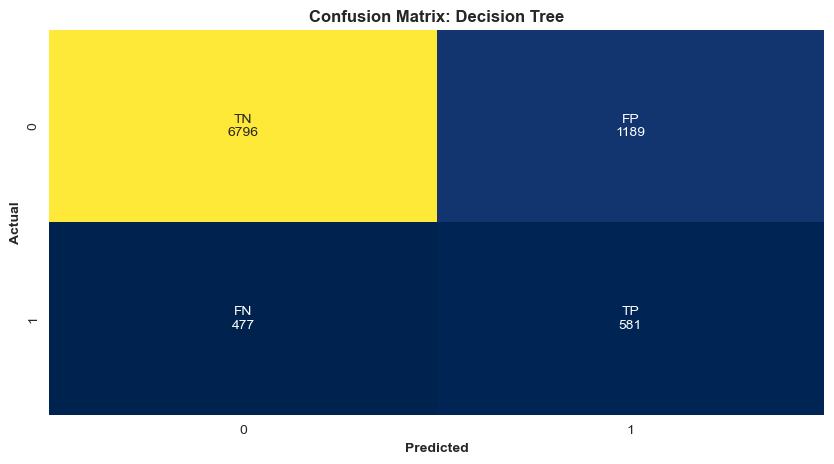

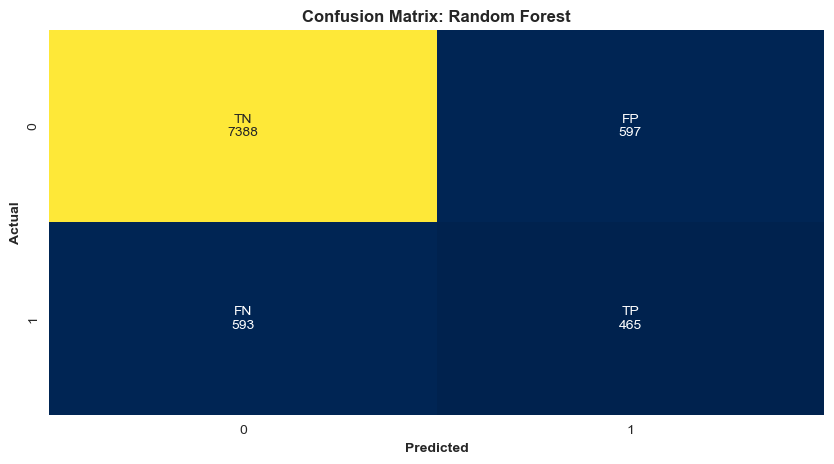

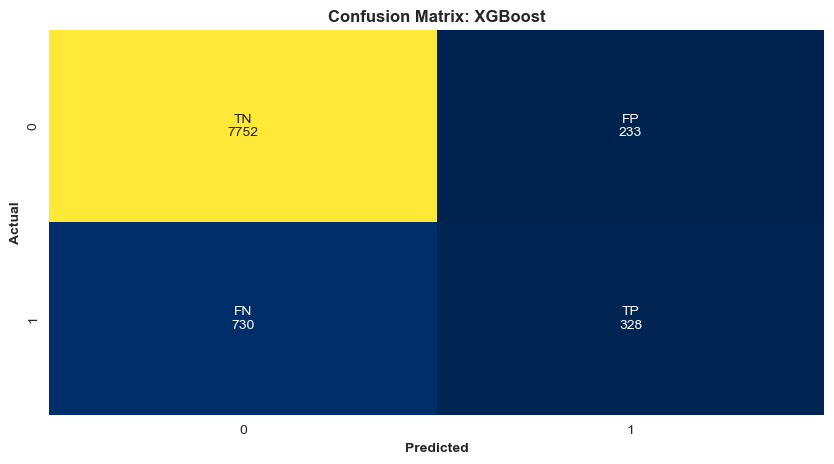

In [45]:
# Function for confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    
    # Assign TP, TN, FP, FN labels
    labels = np.array([["TN", "FP"], ["FN", "TP"]])
    cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
    
    # Annotate with TP, TN, FP, FN
    annot_labels = np.array([[f"TN\n{cm[0,0]}", f"FP\n{cm[0,1]}"],
                             [f"FN\n{cm[1,0]}", f"TP\n{cm[1,1]}"]])
    
    plt.figure(figsize=(10,5))
    sns.heatmap(cm, annot=annot_labels, fmt="", cmap="cividis", cbar=False)
    plt.title(f"Confusion Matrix: {model_name}", fontweight='bold',)
    plt.ylabel("Actual", fontweight='bold')
    plt.xlabel("Predicted", fontweight='bold')
    plt.savefig('images/Confusion Matrix.png', dpi=300, bbox_inches='tight')
    
    plt.show()

# Evaluate each best model and plot confusion matrix

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, name)


In [46]:
metrics_data = []

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_scores)
    avg_precision = average_precision_score(y_test, y_scores)
    
    metrics_data.append({
        "Model": name,
        "Accuracy": acc,
        "ROC-AUC": roc_auc,
        "Avg Precision": avg_precision
    })

metrics_df = pd.DataFrame(metrics_data)

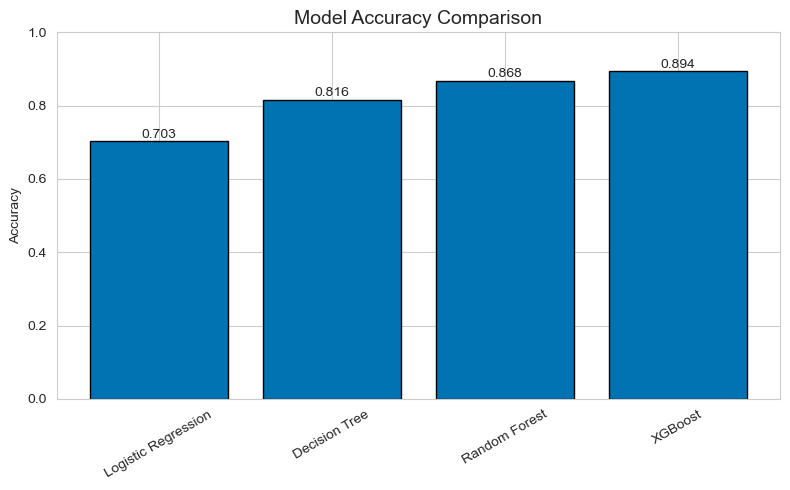

In [47]:
# plot of model Accuracy score

accuracy_scores = {
    name: accuracy_score(y_test, model.predict(X_test))
    for name, model in best_models.items()
}

plt.figure(figsize=(8, 5))
bars = plt.bar(
    accuracy_scores.keys(),
    accuracy_scores.values(),
    edgecolor="black"
)

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{bar.get_height():.3f}",
        ha="center"
    )

plt.ylim(0, 1)
plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('images/Model Accuracy Comparison.png', dpi=300, bbox_inches='tight')
plt.show()


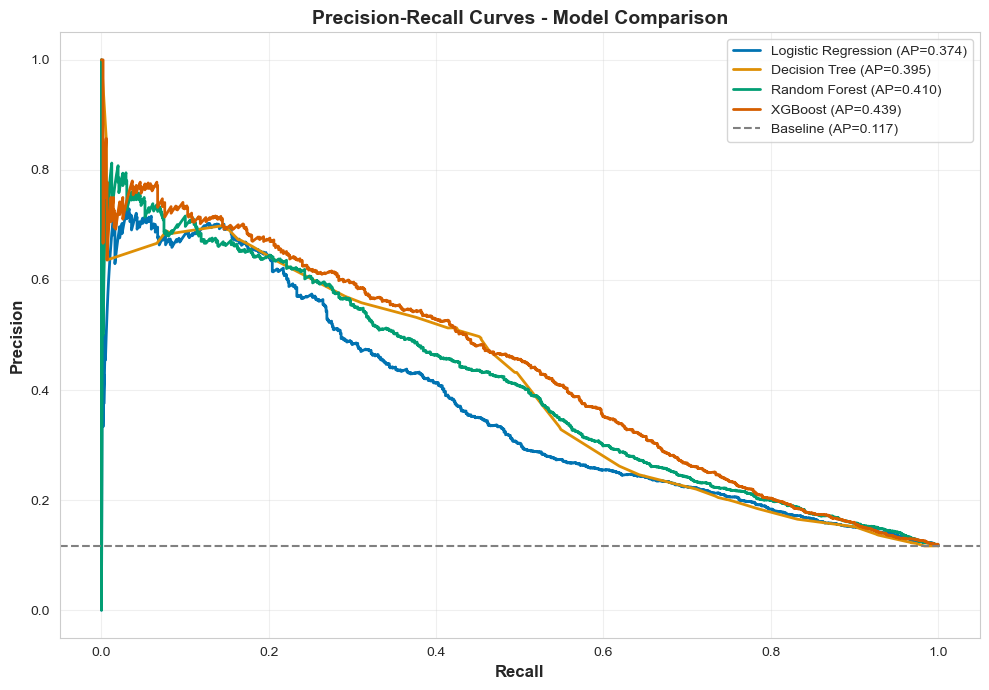

In [49]:
plt.subplots(figsize=(10, 7))

for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, label=f'{name} (AP={ap:.3f})', linewidth=2)

baseline = y_test.mean()
plt.axhline(baseline, linestyle='--', color='gray', label=f'Baseline (AP={baseline:.3f})')
plt.xlabel('Recall', fontweight='bold', fontsize=12)
plt.ylabel('Precision', fontweight='bold', fontsize=12)
plt.title('Precision-Recall Curves - Model Comparison', fontweight='bold', fontsize=14)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('images/Precision-Recall Curves - Model Comparison.png', dpi=300, bbox_inches='tight')
plt.show()



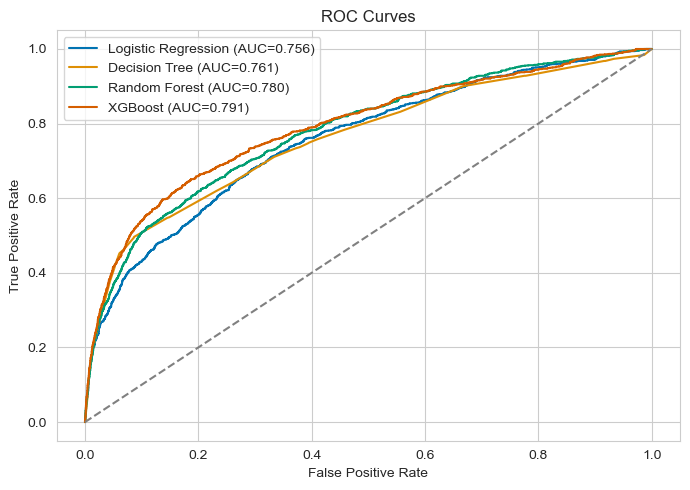

In [50]:
# Plot of ROC Curves
plt.figure(figsize=(7, 5))

for name, model in best_models.items():
    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('images/ROC Curves.png', dpi=300, bbox_inches='tight')
plt.show()


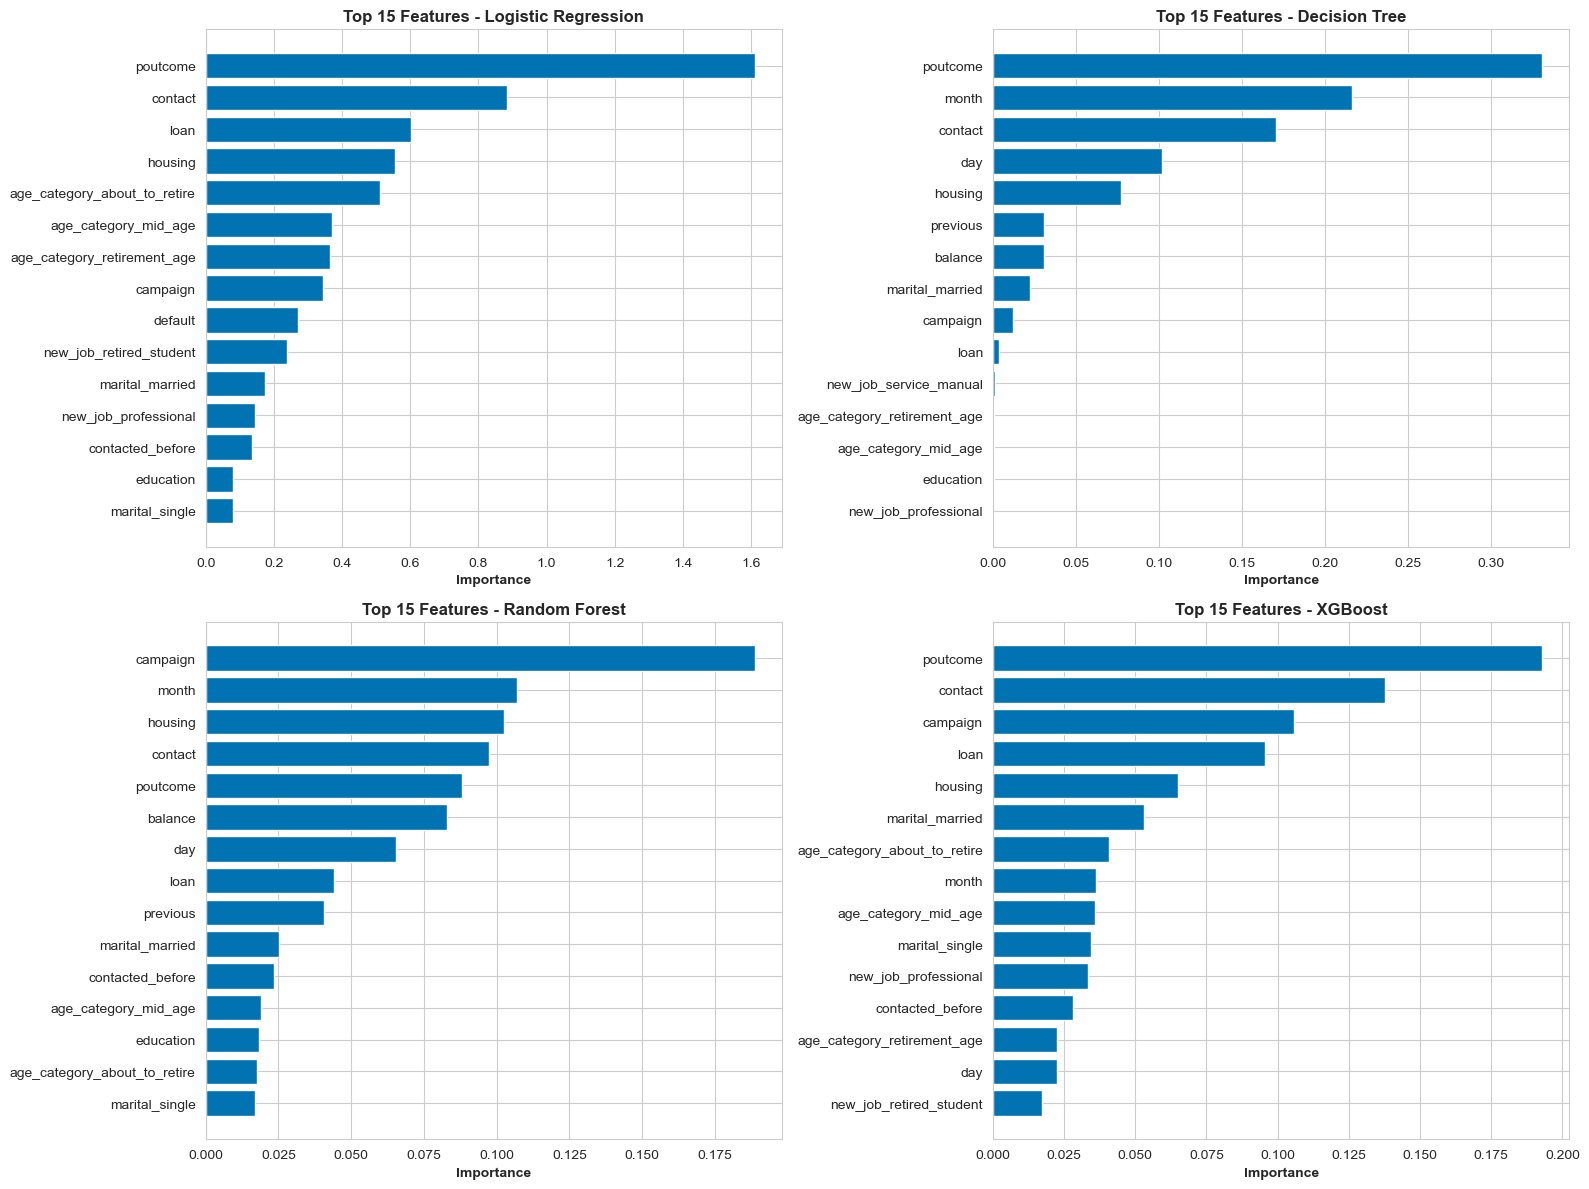

In [51]:
# Feature Importance for models
plt.figure(figsize=(16, 12))

# Get feature names
feature_names = (
    numeric_features +
    [col for col in X_train.columns if col not in numeric_features]
)

for idx, (name, model) in enumerate(best_models.items(), start=1):
    plt.subplot(2, 2, idx)

    if name == "Logistic Regression":
        # Absolute coefficients
        importance = np.abs(model.named_steps['model'].coef_[0])
    else:
        # Feature importance for tree models
        importance = model.named_steps['model'].feature_importances_

    # Get Top 15 features
    indices = np.argsort(importance)[-15:]

    plt.barh(
        range(len(indices)),
        importance[indices]
    )
    plt.yticks(
        range(len(indices)),
        [feature_names[i] for i in indices]
    )
    plt.xlabel('Importance', fontweight='bold')
    plt.title(f'Top 15 Features - {name}', fontweight='bold')

plt.tight_layout()
plt.savefig('Top 15 Features.png', dpi=300, bbox_inches='tight')
plt.show()
